In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import torch
import sys
import os
import numpy as np
%matplotlib inline

#生成等边三角形
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
#每条边中点位置
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    #将三角形顶点的笛卡尔坐标映射到重心坐标系
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)
#有了重心坐标，可以计算Dirichlet概率密度函数的值
class Dirichlet(object):

    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        from functools import reduce
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha]) #reduce:sequence连续使用function

    def pdf(self, x):
        #返回概率密度函数值
        from operator import mul
        from functools import reduce
        return self._coef * reduce(mul, [xx ** (aa - 1) for (xx, aa)in zip(x, self._alpha)])
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    #细分等边三角形网格
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    # 制作数据集
root = "/data/public/renhaoye/morphics/"
subdirs = [os.path.join(root, d) for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
for subdir in subdirs:
    sys.path.append(subdir)
from dataset.galaxy_dataset import *
from utils import schemas
from utils.utils import *
from models.utils import *
import random
from torch.backends import cudnn
def init_rand_seed(rand_seed):
    torch.manual_seed(rand_seed)
    torch.cuda.manual_seed(rand_seed)  # 为当前GPU设置随机种子
    torch.cuda.manual_seed_all(rand_seed)  # 为所有GPU设置随机种子
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
init_rand_seed(1926)
question_answer_pairs = gz2_pairs
dependencies = gz2_and_decals_dependencies
schema = schemas.Schema(question_answer_pairs, dependencies)
def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)
def hwc2chw(img):
    ch1, ch2, ch3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return np.array((ch1, ch2, ch3))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
def cal_total_data_uc(model, x, num_samples):
    batch_size = 1
    num_classes = 34
    probs = torch.zeros(batch_size, num_classes, num_samples, device=x.device)
    entropy = torch.zeros(batch_size, num_classes, num_samples, device=x.device)
    for i in range(num_samples):
        # model.train()
        model.eval()
        with torch.no_grad():
            output, _ = model(x)
        prob = softmax_output(output,schema.question_index_groups)
        # print(prob)
        probs[:, :, i] = prob
        entropy[:, :, i] = -prob * torch.log(prob)
    expected_probs = probs.mean(dim=2)
    variance_probs = ((probs - expected_probs.unsqueeze(2))**2).mean(dim=2)
    data_uc = entropy.mean(dim=2)
    total_uc = -expected_probs * torch.log(expected_probs)
    return expected_probs, total_uc, data_uc, variance_probs
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define the layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Input: 3 channels, Output: 16 channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Input: 16 channels, Output: 32 channels
        self.dropout1 = nn.Dropout2d(p=0.5)  # Dropout after the last convolutional layer
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # Assuming the input image size is 32x32
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout after the first fully connected layer
        self.fc2 = nn.Linear(128, 34)  # Output: 34 classes

    def forward(self, x):
        # Forward pass through the first convolutional layer, then ReLU, then max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)

        # Forward pass through the second convolutional layer, then ReLU, then max pooling, then dropout
        x = self.dropout1(F.max_pool2d(F.relu(self.conv2(x)), 2))

        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        # Forward pass through the first fully connected layer, then ReLU, then dropout
        x = self.dropout2(F.relu(self.fc1(x)))

        # Forward pass through the second fully connected layer
        x = self.fc2(x)

        return x

In [5]:
img = torch.Tensor(load_img("/data/public/renhaoye/morphics/dataset/in_decals/agmtn/119.85429851358965_28.803799075693085.fits"))
# img = torch.Tensor(load_img("/data/public/renhaoye/1.fits"))
device = "cuda:1"
model = torch.load("/data/public/renhaoye/morphics/pth_stn/model_121.pt", map_location=device)

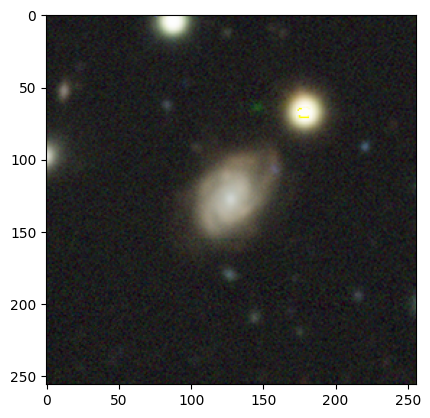

In [4]:
plt.imshow(chw2hwc(load_img("/data/public/renhaoye/morphics/dataset/in_decals/agmtn/119.85429851358965_28.803799075693085.fits")))
plt.show()

In [60]:
predict, stn= model(img.unsqueeze(0).to(device))
predicted = softmax_output(predict,schema.question_index_groups)
fits.writeto(f'/data/public/renhaoye/pth.fits', stn[0].cpu().detach().numpy(), overwrite=True)
predicted

tensor([[6.9901e-02, 8.9974e-01, 3.0359e-02, 1.3439e-02, 9.8656e-01, 9.8178e-01,
         1.8220e-02, 1.6965e-02, 1.8519e-01, 7.9785e-01, 1.0948e-04, 3.1845e-03,
         1.9035e-01, 7.9843e-01, 7.9212e-03, 1.6839e-01, 8.1311e-01, 1.8502e-02,
         8.6536e-02, 2.1346e-01, 7.0000e-01, 6.9394e-01, 2.6944e-01, 3.6612e-02,
         3.4765e-03, 1.8486e-01, 4.2426e-01, 9.0133e-02, 2.9286e-02, 2.6799e-01,
         6.8328e-01, 2.4254e-01, 5.4995e-02, 1.9182e-02]], device='cuda:1',
       grad_fn=<CopySlices>)

In [49]:
probs, a, b, v = cal_total_data_uc(model, img.unsqueeze(0).to(device), 100)
print(probs, a.sum(), b.sum())

tensor([[8.0813e-02, 8.8851e-01, 3.0672e-02, 1.2691e-02, 9.8731e-01, 9.7351e-01,
         2.6489e-02, 1.7423e-02, 1.8617e-01, 7.9640e-01, 1.5478e-04, 4.4588e-03,
         2.1880e-01, 7.6655e-01, 1.0033e-02, 1.4101e-01, 8.4073e-01, 1.8258e-02,
         9.3444e-02, 2.1267e-01, 6.9389e-01, 6.4452e-01, 3.0390e-01, 5.1581e-02,
         5.5192e-03, 1.5927e-01, 3.5587e-01, 1.3277e-01, 2.3922e-02, 3.2264e-01,
         5.9165e-01, 2.9659e-01, 7.7936e-02, 3.3820e-02]], device='cuda:1') tensor(6.2715, device='cuda:1') tensor(6.2143, device='cuda:1')


In [19]:
# random_img = np.random.poisson(0.1, img.shape)
random_img = np.random.normal(0.5, 0.3, img.shape)
random_img = (random_img - random_img.min()) / (random_img.max() - random_img.min())
random_img = torch.Tensor(random_img)
predict, _= model(random_img.unsqueeze(0).to(device))
predicted = softmax_output(predict,schema.question_index_groups)
predicted

tensor([[8.7484e-01, 9.8631e-02, 2.6527e-02, 5.0328e-01, 4.9672e-01, 1.4217e-02,
         9.8578e-01, 2.8813e-01, 1.1683e-02, 7.0019e-01, 6.0038e-02, 1.7495e-02,
         6.3473e-03, 1.9365e-02, 8.9675e-01, 9.6217e-02, 3.4841e-01, 5.5537e-01,
         1.3609e-01, 3.4368e-01, 5.2023e-01, 8.1028e-01, 4.3632e-02, 1.4609e-01,
         1.4594e-04, 5.7260e-02, 4.3025e-01, 4.3581e-02, 4.5562e-02, 4.2320e-01,
         9.9110e-01, 8.3890e-03, 1.0408e-04, 4.0940e-04]], device='cuda:1',
       grad_fn=<CopySlices>)

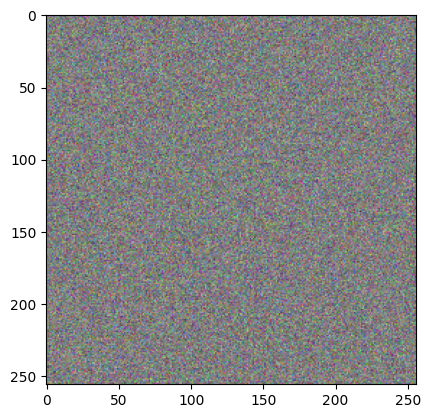

In [18]:
plt.imshow(chw2hwc(random_img))

In [16]:
probs, a, b, v = cal_total_data_uc(model, random_img.unsqueeze(0).to(device), 100)
probs, a.sum(), b.sum(), v.sum()

(tensor([[0.7576, 0.1842, 0.0582, 0.7394, 0.2606, 0.0372, 0.9628, 0.5446, 0.0405,
          0.4149, 0.2799, 0.0584, 0.0291, 0.2230, 0.4095, 0.2820, 0.1243, 0.5937,
          0.1613, 0.3034, 0.5353, 0.8554, 0.0891, 0.0555, 0.0055, 0.1163, 0.1119,
          0.1236, 0.3875, 0.2551, 0.9763, 0.0174, 0.0010, 0.0054]],
        device='cuda:1'),
 tensor(7.6246, device='cuda:1'),
 tensor(6.1128, device='cuda:1'),
 tensor(0.8871, device='cuda:1'))

In [28]:
v

tensor([[8.7317e-03, 7.0009e-03, 1.2927e-03, 4.5906e-02, 4.5906e-02, 9.6376e-03,
         9.6376e-03, 6.5038e-02, 5.0186e-03, 4.0929e-02, 9.7891e-02, 3.2694e-03,
         1.2621e-03, 4.1730e-02, 3.0242e-02, 7.8861e-02, 7.0336e-03, 9.4658e-02,
         9.7393e-03, 2.3876e-02, 3.1553e-02, 1.1891e-02, 3.0246e-03, 5.9841e-03,
         9.1619e-05, 5.4059e-02, 2.5710e-03, 1.2205e-02, 6.7811e-02, 2.1172e-02,
         2.1751e-04, 1.4652e-04, 1.6445e-06, 3.9831e-06]], device='cuda:1')

In [53]:
poisson = np.random.poisson(0.01, img.shape)
poisson_img = hwc2chw(chw2hwc(img)+chw2hwc(poisson))
plt.imshow(chw2hwc(poisson_img))
poisson_img = torch.Tensor(poisson_img)
probs, a, b, v = cal_total_data_uc(model, poisson_img.unsqueeze(0).to(device), 100)
print(probs, a.sum(), b.sum())

tensor([[[[0.3333, 0.2119, 0.3333,  ..., 0.3333, 0.3333, 0.3333],
          [0.3333, 0.3333, 0.3333,  ..., 0.2119, 0.3333, 0.3333],
          [0.3333, 0.3333, 0.2119,  ..., 0.5761, 0.3333, 0.3333],
          ...,
          [0.3333, 0.3333, 0.1554,  ..., 0.3333, 0.3333, 0.3333],
          [0.3333, 0.5761, 0.2119,  ..., 0.3333, 0.2119, 0.3333],
          [0.3333, 0.2119, 0.2119,  ..., 0.3333, 0.3333, 0.5761]],

         [[0.3333, 0.5761, 0.3333,  ..., 0.3333, 0.3333, 0.3333],
          [0.3333, 0.3333, 0.3333,  ..., 0.5761, 0.3333, 0.3333],
          [0.3333, 0.3333, 0.2119,  ..., 0.2119, 0.3333, 0.3333],
          ...,
          [0.3333, 0.3333, 0.4223,  ..., 0.3333, 0.3333, 0.3333],
          [0.3333, 0.2119, 0.5761,  ..., 0.3333, 0.5761, 0.3333],
          [0.3333, 0.5761, 0.5761,  ..., 0.3333, 0.3333, 0.2119]],

         [[0.3333, 0.2119, 0.3333,  ..., 0.3333, 0.3333, 0.3333],
          [0.3333, 0.3333, 0.3333,  ..., 0.2119, 0.3333, 0.3333],
          [0.3333, 0.3333, 0.5761,  ..., 0

(tensor([[0.4973, 0.4603, 0.0425, 0.0190, 0.9810, 0.7498, 0.2502, 0.0061, 0.0923,
          0.9016, 0.0018, 0.0041, 0.0384, 0.4139, 0.5418, 0.0643, 0.9257, 0.0100,
          0.1364, 0.4242, 0.4394, 0.6506, 0.2583, 0.0912, 0.0338, 0.1362, 0.1091,
          0.0376, 0.0175, 0.6658, 0.6344, 0.2882, 0.0626, 0.0148]],
        device='cuda:1'),
 tensor(6.8107, device='cuda:1'),
 tensor(6.7236, device='cuda:1'))

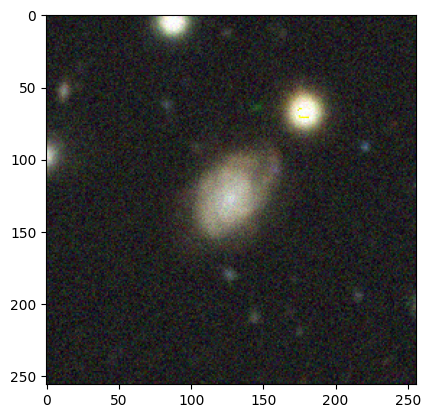

In [62]:
normal = np.random.normal(0.01, 0.05, img.shape)
normal_img = hwc2chw(chw2hwc(img)+chw2hwc(normal))
plt.imshow(chw2hwc(normal_img))
normal_img = torch.Tensor(normal_img)
probs, a, b, v = cal_total_data_uc(model, normal_img.unsqueeze(0).to(device), 100)
(probs, a.sum(), b.sum())

In [10]:
target_layer = list(list(model.children())[0].children())[-2]
target_layer

AdaptiveAvgPool2d(output_size=1)

In [9]:
from astropy.io import fits

# 打开 FITS 文件
hdul = fits.open('/data/public/renhaoye/ccds-annotated-mosaic-dr9.fits.gz')  # 替换为你的文件名
# 打开第一个 HDU 的 header
header = hdul[1].header


In [10]:
header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  627 / length of dimension 1                          
NAXIS2  =               241299 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   90 / number of table fields                         
TTYPE1  = 'image_filename'                                                      
TFORM1  = '120A    '                                                            
TTYPE2  = 'image_hdu'                                                           
TFORM2  = 'I       '                                                            
TTYPE3  = 'camera  '        

In [11]:
data = hdul[1].data

In [12]:
data

FITS_rec([('mosaic/CP/V4.3/CP20151118/k4m_151119_105658_ooi_zd_ls9.fits.fz', 1, 'mosaic', 151119105658, 'V4.3', '2019-11-13T00:12:24', '9611d52', 'CCD1', 'COSMOS zd 2015nov19ut', '2015B-2001', 'z', 30.104, 57345.45622685, 1.4823278, 10.03    , 4054, 4079, 150.09304167,  2.22333333, 4157.6445  , 4186.93    , 150.09304167,  2.22333333,  9.75680408e-08, 7.2123010e-05, 7.2118819e-05, -2.64884534e-07,  1, 149.93713698,  2.06952379, 1.3148277, 0.04528041, 26.170532, 26.185707, -0.00605668, -0.02319728, 74.00089 , 18.970413, 0.05366999, 0.03777841, 0.05003763, 0.04851621, 297, 375, 0,  1, [-1, -1, -1, -1], 149.79351515,  1.92754314, 150.0844991 ,  1.92382389, 150.08517135,  2.21578135, 149.79118985,  2.21656585, 0.1475805 , 0.14666224, 149.9371353 ,  2.06951734, 2.4798155, 0.01954333, 2.5201883, 2.4666839, 0.25803697, 0.00266166, 0.2618963 , 0.25162697, 0.05665391, 0.00099346, 0.05319767, 0.00080966, 27.249025 , 36.81714  , -1.4888701 , 6.086334 , 5.198336 , -81.35654 , 0.1459003 , nan, nan, 